<a href="https://colab.research.google.com/github/JairoRotava/UFPEL/blob/main/aed/delta_encoding_e_move_to_front_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Delta encoding & Move-to-front transform
Trabalho final disciplina Algoritmos e estruturas de dados - UFPEL

Aluno: Jairo Rotava

## Introdução

Delta encoding e Move-to-front transform são algoritmos utilizados para auxiliar na compressão de dados. Ambos os algortimos alteram a sequência de dados de tal forma que a melhorar a eficiência de compressão de algortimos posteriores. Geralmentes estes dois algoritmos são utilizados em conjunto com um ou mais algoritmos.

# Delta encoding

Delta encoding é uma forma de representação que armazena as diferenças (deltas) entre dados sequênciais. Por exemplo, quando um arquivo de texto é modificado, ao invés de ser gerado um novo arquivo completo, somente as alterações são armazenadas.

Por exemplo a sequencia 2, 4, 6, 9, 7, pode ser armazenada usando a diferença entre os dados: 2, 2, 2, 3, -2. O sinal codificado tem uma variância menor que o original, e isso permite utilizar um número menores de bits para representar um mesmo dado.

A natureza do dado a ser codificado influencia na eficiência do algoritmo, e nem todos tipos de dados podem ser comprimidos utilizando delta encoding. O algoritmo funciona melhor quando existe uma variação pequena ou constante entre dados vizinhos.

## Exemplo de uso
- Delta copying: copia somente a parte do arquivo alterada para aumentar velocidade. Pode ser utilizado em backups.
- Diff: programa para comparação de arquivos
- Git: utilizar delta compression como parte do mecanismo de compressão dos arquivos
- Compressão de audio
- Compressão de video

## Exemplo algoritmo em python
Código original (convertido para python): https://en.wikipedia.org/wiki/Delta_encoding

In [1]:
def delta_encode(buffer):
    last = 0;
    buffer_out = [None] * len(buffer)
    for i in range(len(buffer)):
        current = buffer[i]
        buffer_out[i] = current - last
        last = current
    return buffer_out


def delta_decode(buffer):
    last = 0
    buffer_out = [None] * len(buffer)
    for i in range(len(buffer)):
        delta = buffer[i]
        buffer_out[i] = delta + last
        last = buffer_out[i]
    return buffer_out

### Exemplo ASCII
Delta encoding aplicado em texto ASCII. A sequência codificada pode ser representeda, em média, com simbolos com menor número de bits.

In [2]:
original_sequence = [ord(l) for l in list('panama')]
delta_sequence = delta_encode(original_sequence)
delta_decoded_sequence = delta_decode(delta_sequence)

print("Sequencia ASCII original: {}".format(original_sequence))
print("Sequencia codificada com delta: {}".format(delta_sequence))
print("Sequencia decodificada: {}".format(delta_decoded_sequence))

Sequencia ASCII original: [112, 97, 110, 97, 109, 97]
Sequencia codificada com delta: [112, -15, 13, -13, 12, -12]
Sequencia decodificada: [112, 97, 110, 97, 109, 97]


### Exemplo seno
Delta encoding aplicado numa função comportada. Note que a variância do dado codificado é menor que o original.

Sinal original min/max: -125 / 125 ~> 8 bits
Sinal delta encoding min/max: -13 / 13 ~> 5 bits


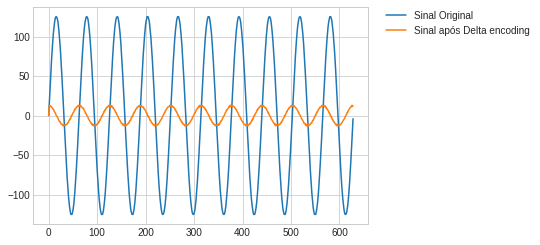

In [3]:
import numpy
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

x = numpy.arange(0,10*2*numpy.pi, 0.1)
seno = (numpy.sin(x)* 126).astype(int)
delta_seno = delta_encode(seno)
plt.plot(seno,label='Sinal Original')
plt.plot(delta_seno, label='Sinal após Delta encoding')
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

print("Sinal original min/max: {} / {} ~> {} bits".format(min(seno),max(seno), 1 + int(max(seno)).bit_length() ))
print("Sinal delta encoding min/max: {} / {} ~> {} bits".format(min(delta_seno),max(delta_seno), 1 + int(max(delta_seno)).bit_length() ))

## Referências
- https://en.wikipedia.org/wiki/Delta_encoding
- https://medium.com/ably-realtime/delta-compression-a-practical-guide-to-diff-algorithms-and-delta-file-formats-4e070cc59add
- https://docs.aws.amazon.com/redshift/latest/dg/c_Delta_encoding.html
- https://fileformats.fandom.com/wiki/Delta_encoding

# Move-to-front transform

Move-to-front (MTF) enconding transform é uma codificação de uma sequencia de bytes com objetivo de facilitar o compressão por outras técnicas. A idéia do move-to-front é pré-processar a mensagem convertendo em um sequência de inteiros, onde existe uma tendência para valores baixos. Posteriormente algum algoritmo de compressão probabilistico (exemplo Huffman) é utilizado para codificar os inteiros. O MTF geralmente é utilizado após o Burrows–Wheeler transform (BWT).

O ponto chave é que símbolos que ocorrem com maior frequência tendem a ficar no início do dicionário, e símbolos menos frequentes ficam no final.  Assim, utilizando codigos menores para as posição iniciais, garantimos que os códigos mais frequentes utilizem um menor número de bits na representação.

Este algoritmo foi publicado por B. Ryabko em 1980, e J.K Benteley et. al. em 1986.

É um algoritmo que não comprime os dados, mas pode ajudar reduzir redundância, diminuindo a entropia, quando um simbolo que apareceu recentemente é repetido. A principal idéia é que cada simbolo seja substituído por um índice numa lista de simbolos recentes (ou dicionário). Os símbolos com maior frequência acabam ficando do dicionário. 

## Algoritmo

Ao invés de utilizar o valor do símbolo (vamos assumir byte), o algoritmo utiliza a posição, ou índice, desse simbolo numa tabela que contém todos os símbolos. A tabela é iniciada com todos os símbolos, e a posição deles é atualizada conforme os dados são processados. O símbolo mais recente é colocado na posição 0 da tabela e assim por diante. Essa técnica coloca os símbolos mais utilizados, com maior frequência, no início da tabela.

## Exemplo algoritmo em python
Código original (modificado para apresentar resultados intermediários): https://en.wikipedia.org/wiki/Move-to-front_transform

In [4]:
# https://en.wikipedia.org/wiki/Move-to-front_transform
from typing import List, Tuple, Union
# Instead of always transmitting an "original" dictionary, it is simpler to just agree on an initial set.
# Here we use the 256 possible values of a byte:
# 97 - 122 para letras minuscuals
#common_dictionary = list(range(97,122))

def mtf_encode(plain_text: str,common_dictionary, verbose=False ) -> List[int]:
    # Change to bytes for 256.
    plain_text = plain_text.encode('utf-8')

    # Changing the common dictionary is a bad idea. Make a copy.
    dictionary = common_dictionary.copy()
    if verbose:
        print("Dicionario inicial: {}".format(bytes(dictionary).decode('utf-8')))

    # Transformation
    compressed_text = list()          # Regular array
    rank = 0

    # Read in each character
    for c in plain_text:
        rank = dictionary.index(c)    # Find the rank of the character in the dictionary [O(k)]
        compressed_text.append(rank)  # Update the encoded text

        # Update the dictionary [O(k)]
        dictionary.pop(rank)
        dictionary.insert(0, c)
        if verbose:
            print("entrada: {}\t saida: {}\t dicionario: {}".format(chr(c), compressed_text, bytes(dictionary).decode('utf-8')))

    return compressed_text            # Return the encoded text

def mtf_decode(compressed_data: List[int], common_dictionary, verbose=False) -> str:
    compressed_text = compressed_data
    dictionary = common_dictionary.copy()
    if verbose:
        print("Dicionario inicial: {}".format(bytes(dictionary).decode('utf-8')))

    plain_text = []

    # Read in each rank in the encoded text
    for rank in compressed_text:
        # Read the character of that rank from the dictionary
        plain_text.append(dictionary[rank])

        # Update the dictionary
        e = dictionary.pop(rank)
        dictionary.insert(0, e)
        if verbose:
            print("entrada: {}\t saida: {}\t dicionario: {}".format(rank, bytes(plain_text).decode('utf-8'), bytes(dictionary).decode('utf-8')))

        
    return bytes(plain_text).decode('utf-8')  # Return original string

## Exemplo ASCII
Move-to-front aplicado em sequência ASCII. Neste exemplo assumimos que o dicionário é a sequência ASCII dos caracteres minúsculos para facilitar a visualização

In [5]:
short_dict = list(range(97,122))
print("Encode")
mtf_sequence = mtf_encode("panama", short_dict, verbose=True)
print("MTF enconded: {}".format(mtf_sequence))
print("\nDecode")
mtf_decoded_sequence = mtf_decode(mtf_sequence, short_dict, verbose=True)
print("Decodificado: {}".format(mtf_decoded_sequence))

Encode
Dicionario inicial: abcdefghijklmnopqrstuvwxy
entrada: p	 saida: [15]	 dicionario: pabcdefghijklmnoqrstuvwxy
entrada: a	 saida: [15, 1]	 dicionario: apbcdefghijklmnoqrstuvwxy
entrada: n	 saida: [15, 1, 14]	 dicionario: napbcdefghijklmoqrstuvwxy
entrada: a	 saida: [15, 1, 14, 1]	 dicionario: anpbcdefghijklmoqrstuvwxy
entrada: m	 saida: [15, 1, 14, 1, 14]	 dicionario: manpbcdefghijkloqrstuvwxy
entrada: a	 saida: [15, 1, 14, 1, 14, 1]	 dicionario: amnpbcdefghijkloqrstuvwxy
MTF enconded: [15, 1, 14, 1, 14, 1]

Decode
Dicionario inicial: abcdefghijklmnopqrstuvwxy
entrada: 15	 saida: p	 dicionario: pabcdefghijklmnoqrstuvwxy
entrada: 1	 saida: pa	 dicionario: apbcdefghijklmnoqrstuvwxy
entrada: 14	 saida: pan	 dicionario: napbcdefghijklmoqrstuvwxy
entrada: 1	 saida: pana	 dicionario: anpbcdefghijklmoqrstuvwxy
entrada: 14	 saida: panam	 dicionario: manpbcdefghijkloqrstuvwxy
entrada: 1	 saida: panama	 dicionario: amnpbcdefghijkloqrstuvwxy
Decodificado: panama


## Referências
- https://web.archive.org/web/20001003063538/http://www.arturocampos.com/ac_mtf.html
- https://sites.google.com/site/datacompressionguide/mtf
- http://www.data-compression.info/Algorithms/MTF/index.html
- https://www.geeksforgeeks.org/move-front-data-transform-algorithm/
- http://www.cim.mcgill.ca/~langer/423/lecture8.pdf
- http://multimedia.ufp.pt/codecs/compressao-sem-perdas/supressao-de-sequencias-repetitivas/transformada-move-to-front/

## Demonstração aplicação de mtf com compressão Huffman
A seguir vamos demonstrar os efeitos da aplicação de mtf com o algoritmo de huffman na eficiência da compressão. também vamos precisar do algoritmo Burrows-Wheeler transform, que rearranja a ordem do texto, também com o objetivo de melhorar a compressão.

### Algortimo codificação de Huffman
A codificação de Huffman troca os símbolos por bits, de forma a atribuir os códigos com menores números de bits para os símbolos mais frequentes, e dessa forma realiza a compressão dos dados.

In [6]:
import numpy as np
#from scipy.stats import entropy
import scipy.stats as st
from math import log, e

def entropy(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  return st.entropy(counts, base=base)

# https://www.openbookproject.net/py4fun/huffman/huffman.html
# Codificacao de huffman
import sys, string

codes   = {}

def frequency (str) :
    freqs = {}
    for ch in str :
        freqs[ch] = freqs.get(ch,0) + 1
    return freqs

def sortFreq (freqs) :
    letters = freqs.keys()
    tuples = []
    for let in letters :
        tuples.append((freqs[let],let))
    tuples.sort()
    return tuples

def buildTree(tuples) :
    while len(tuples) > 1 :
        leastTwo = tuple(tuples[0:2])                  # get the 2 to combine
        theRest  = tuples[2:]                          # all the others
        combFreq = leastTwo[0][0] + leastTwo[1][0]     # the branch points freq
        tuples   = theRest + [(combFreq,leastTwo)]     # add branch point to the end
        tuples = sorted(tuples, key=lambda x: x[0])
    return tuples[0]            # Return the single tree inside the list 

def trimTree (tree) :
     # Trim the freq counters off, leaving just the letters
    p = tree[1]                                    # ignore freq count in [0]
    if type(p) == type("") : return p              # if just a leaf, return it
    else : return (trimTree(p[0]), trimTree(p[1])) # trim left then right and recombine

def assignCodes (node, pat='') :
    global codes
    if type(node) == type("") :
        codes[node] = pat                # A leaf. set its code
    else  :                              # 
        assignCodes(node[0], pat+"0")    # Branch point. Do the left branch
        assignCodes(node[1], pat+"1")    # then do the right branch. 

def encode (str) :
    global codes
    output = ""
    for ch in str : output += codes[ch]
    return output

def decode (tree, str) :
    output = ""
    p = tree
    for bit in str :
        if bit == '0' : p = p[0]     # Head up the left branch
        else          : p = p[1]     # or up the right branch
        if type(p) == type("") :     
            output += p              # found a character. Add to output
            p = tree                 # and restart for next character
    return output

def test_huffman(message):
    """ rotina para teste da codificacao de huffman"""
    debug = None
    freqs = frequency(message)
    tuples = sortFreq(freqs)

    tree = buildTree(tuples)
    if debug : print("Built tree %s" % tree)

    tree = trimTree(tree)
    if debug : print("Trimmed tree" % tree)

    assignCodes(tree)
    if debug : showCodes()

    small = encode(message)
    original = decode (tree, small)
    
    text_entropy = entropy(list(message), base=2)
    print("Entropia: {}".format(text_entropy))
    l_original = len(message)
    l_comp = (len(small)+7)/8
    print("Comprimento original/comprimido: {}/{} bytes ~ {}".format( l_original, l_comp, l_original/l_comp))
    if (message != original):
        print("Erro! Arquivo restaurado diferente de original" % (message == original))

### Algoritmo Burrows-Wheeler transform
Algoritmo axiliar, que reorganiza os símbolos de forma a melhorar o desempenho de algortimos posteriores

In [7]:
# https://en.wikipedia.org/wiki/Burrows%E2%80%93Wheeler_transform
def bwt(s: str) -> str:
    """Apply Burrows–Wheeler transform to input string."""
    assert "\002" not in s and "\003" not in s, "Input string cannot contain STX and ETX characters"
    s = "\002" + s + "\003"  # Add start and end of text marker
    table = sorted(s[i:] + s[:i] for i in range(len(s)))  # Table of rotations of string
    last_column = [row[-1:] for row in table]  # Last characters of each row
    return "".join(last_column)  # Convert list of characters into string

def ibwt(r: str) -> str:
    """Apply inverse Burrows–Wheeler transform."""
    table = [""] * len(r)  # Make empty table
    for i in range(len(r)):
        table = sorted(r[i] + table[i] for i in range(len(r)))  # Add a column of r
    s = [row for row in table if row.endswith("\003")][0]  # Find the correct row (ending in ETX)
    return s.rstrip("\003").strip("\002")  # Get rid of start and end markers

### Texto  para teste

In [8]:
# Texto para teste compressao
original_text = """To be, or not to be, that is the question:
Whether 'tis nobler in the mind to suffer
The slings and arrows of outrageous fortune,
Or to take Arms against a Sea of troubles,
And by opposing end them: to die, to sleep;
No more; and by a sleep, to say we end
The heart-ache, and the thousand natural shocks
That Flesh is heir to? 'Tis a consummation
Devoutly to be wished. To die, to sleep,
To sleep, perchance to Dream; aye, there's the rub,
For in that sleep of death, what dreams may come,
When we have shuffled off this mortal coil,
Must give us pause. There's the respect
That makes Calamity of so long life:
For who would bear the Whips and Scorns of time,
The Oppressor's wrong, the proud man's Contumely,
The pangs of dispised Love, the Law’s delay,
The insolence of Office, and the spurns
That patient merit of th'unworthy takes,
When he himself might his Quietus make
With a bare Bodkin? Who would Fardels bear, [F: these Fardels]
To grunt and sweat under a weary life,
But that the dread of something after death,
The undiscovered country, from whose bourn
No traveller returns, puzzles the will,
And makes us rather bear those ills we have,
Than fly to others that we know not of?
Thus conscience does make cowards of us all,
And thus the native hue of Resolution
Is sicklied o'er, with the pale cast of Thought,
And enterprises of great pitch and moment, [F: pith]
With this regard their Currents turn awry, [F: away]
And lose the name of Action. Soft you now,
The fair Ophelia? Nymph, in thy Orisons
Be all my sins remember'd."""

### Huffman

In [9]:
message = original_text
test_huffman(message)

Entropia: 4.533577185051671
Comprimento original/comprimido: 1537/878.25 bytes ~ 1.7500711642470823


### mtf + huffman

In [10]:
message = original_text
# Cria dicionario para texto original
my_dict = list(set(message.encode('utf-8')))
# Aplica mtf
mtf = bytes(mtf_encode(message, my_dict)).decode('utf-8')
test_huffman(mtf)

Entropia: 5.0122903167373645
Comprimento original/comprimido: 1539/969.5 bytes ~ 1.587416193914389


### bwt + mtf + huffman

In [11]:
message = bwt(original_text)
# Cria dicionario para texto original
my_dict = list(set(message.encode('utf-8')))
# Aplica mtf
mtf = bytes(mtf_encode(message, my_dict)).decode('utf-8')
test_huffman(mtf)

Entropia: 4.12795400086182
Comprimento original/comprimido: 1541/799.25 bytes ~ 1.9280575539568345


In [12]:
# Como ficou o texto rearranjado pelo bwt?
message

"\x03.,,],,s,n,:n,;n,,sts,,d,,r,?],,,:e]?rfeessrodeted?freysfda..f.e?,,,thsyrgsesss;ht,,d:n;aooodrseddelysaderfsoofeetegdens,tfoeeneseteerr,ehteygodsstddstfedosleedswrudeeetpsssydtsastdy,ofeets,t:e,esssereolesytooaoeffeodoyf,nts,rtnesh,sssddsdd,:fhrednfeyt:y,,,drrofstefesynsta,rmee,oost roneer hstllebleeewyyhpseytreeyhepseegepeehrtdnedenFFFmpemfoan \n\n\n\n\n \n \n   \n [[[   \n\n\n  \n\n\n    \n      \n\n\n\n\n\n\n\n\n\n\n  \n'\x02 \n\n\n\n\n  \n\n   ysh   e  i-e  rgfmtmmmttrCp  enlehmh    s   peeegFFwb eechhhhhehheheerpmnnphhr  Lmslw u       mou    nnnitrasio    S s eAnlennlnnennnunneaennnrnnn'e   rrn  n o   rkkrshhhBslkchwhwwhhvshwhhhmcuhhhhhhvhhshchvhbrrfnvmmchbbvyiisfrSrrrbbbhwrwddpsrilhlllllrhhdshvddmhmrhhil  im rgeeeeefhdhtllb'phhvmthkoslklkhlRrruhmriDoooooooloooofoooo iifouOuff   oannnnaeaiu   nntcsttttpttTcTwtTTttt  tTttTT TttttTttttTttTtc st ptWWttTtttW tW ttWwswtTtgg sTtttlfsddlctullmow th   kmhsls attttheaehT hth dprwrdrpWwWpmtgaaaaaadc calalliaeuuafsssssoblzbFeek  saiaei  

## Conclusão
Os algoritmos delta encoding e move to front são algortimos auxiliares na tarefa de compressão de dados. Ambos os algoritmos transformam os dados de entrada para permitir que outros algoritmos aplicados posteriormente consigam realizar uma melhor compressão dos dados. Para alguns tipos de dados a melhora da compressão pode ser significativa.
